In [36]:
from forge.workflows.adversarial_attack.workflow_setup import prepare_aa_workflow
from forge.core.database import DatabaseManager

In [37]:
db_manager = DatabaseManager()

In [10]:
dimer_structures_ids = db_manager.find_structures_by_metadata(
    metadata_filters={
        'config_type': 'dimer'
    }
)

In [11]:
dimers = db_manager.get_batch_atoms_with_calculation(dimer_structures_ids)

In [12]:
gen_7_structures_ids = db_manager.find_structures_by_metadata(
    metadata_filters={
        'generation': '7'
    }
)

gen_7_structures_ids = list(set(gen_7_structures_ids) - set(dimer_structures_ids))


gen_7_structures = db_manager.get_batch_atoms_with_calculation(gen_7_structures_ids)


In [13]:
gen_7_plus_dimers = dimers + gen_7_structures

gen_7_plus_dimers_ids = gen_7_structures_ids + dimer_structures_ids


In [16]:
import numpy as np
k_b = 8.617e-5
temperature = np.linspace(1,1000,1000)

calculations = db_manager.get_calculations_batch(gen_7_plus_dimers_ids)


Global min exp_term: -5.2977e+05
Global max exp_term: 1.1030e+05
Range: 6.4007e+05

Summary Statistics:
+--------------------+------------+
| Statistic          |      Value |
+====================+============+
| Global Minimum     | -529770    |
+--------------------+------------+
| Global Maximum     |  110300    |
+--------------------+------------+
| Range              |  640070    |
+--------------------+------------+
| Mean               |     701.24 |
+--------------------+------------+
| Median             |     187.62 |
+--------------------+------------+
| Standard Deviation |    3797.4  |
+--------------------+------------+


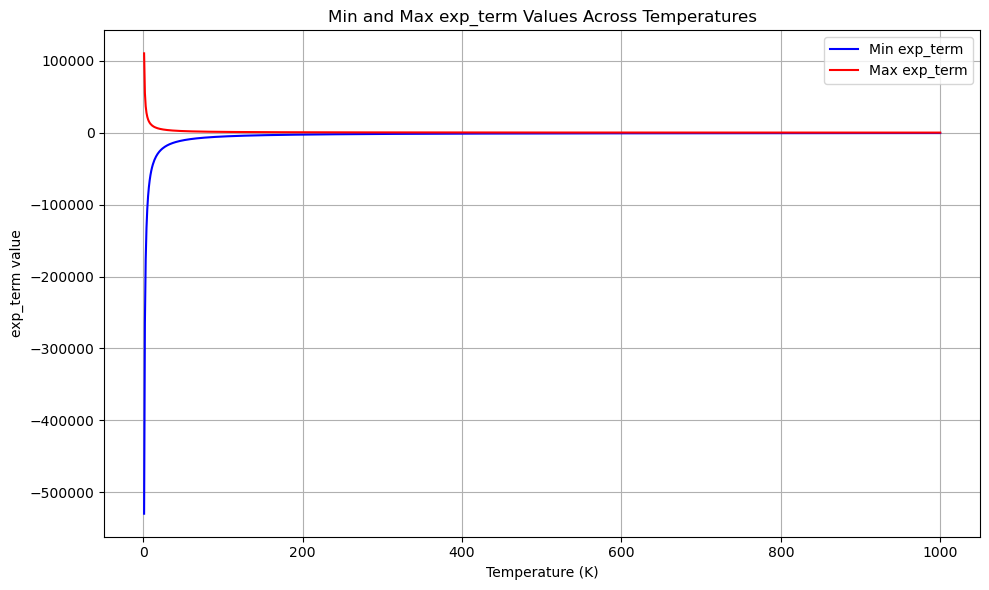

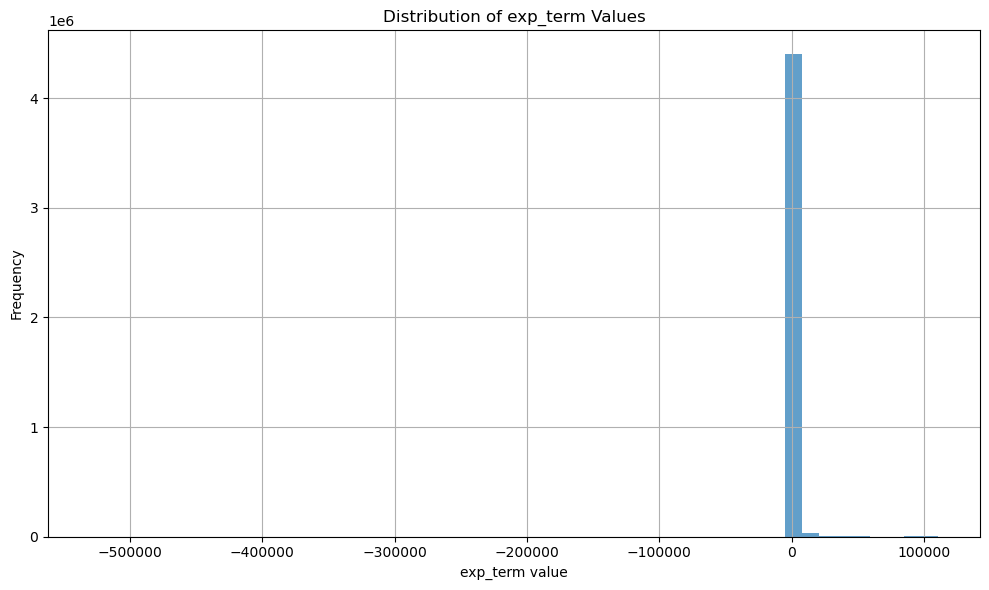

In [24]:
energies = []
for key, value in calculations.items():
    energies.append(value['energy']/len(value['forces']))
energies = np.array(energies)

# Reshape energies to column vector for broadcasting with temperature
energies = energies.reshape(-1, 1)

# Calculate exp_term - this will be a 2D array (n_structures × n_temperatures)
exp_term = -energies / (k_b * temperature)

# Find global min and max across the entire 2D array
min_val = np.min(exp_term)
max_val = np.max(exp_term)

# If you need min/max per structure or per temperature:
min_per_structure = np.min(exp_term, axis=1)  # Min across temperatures for each structure
max_per_structure = np.max(exp_term, axis=1)  # Max across temperatures for each structure
min_per_temp = np.min(exp_term, axis=0)       # Min across structures for each temperature
max_per_temp = np.max(exp_term, axis=0)       # Max across structures for each temperature

# Visualize the min and max values for easy reporting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Print summary statistics
print(f"Global min exp_term: {min_val:.4e}")
print(f"Global max exp_term: {max_val:.4e}")
print(f"Range: {max_val - min_val:.4e}")

# Create a table of summary statistics
summary_table = [
    ["Statistic", "Value"],
    ["Global Minimum", f"{min_val:.4e}"],
    ["Global Maximum", f"{max_val:.4e}"],
    ["Range", f"{max_val - min_val:.4e}"],
    ["Mean", f"{np.mean(exp_term):.4e}"],
    ["Median", f"{np.median(exp_term):.4e}"],
    ["Standard Deviation", f"{np.std(exp_term):.4e}"]
]
print("\nSummary Statistics:")
print(tabulate(summary_table, headers="firstrow", tablefmt="grid"))

# Plot min/max values across temperatures
plt.figure(figsize=(10, 6))
plt.plot(temperature, min_per_temp, 'b-', label='Min exp_term')
plt.plot(temperature, max_per_temp, 'r-', label='Max exp_term')
plt.xlabel('Temperature (K)')
plt.ylabel('exp_term value')
plt.title('Min and Max exp_term Values Across Temperatures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of exp_term values
plt.figure(figsize=(10, 6))
plt.hist(exp_term.flatten(), bins=50, alpha=0.7)
plt.xlabel('exp_term value')
plt.ylabel('Frequency')
plt.title('Distribution of exp_term Values')
plt.grid(True)
plt.tight_layout()
plt.show()


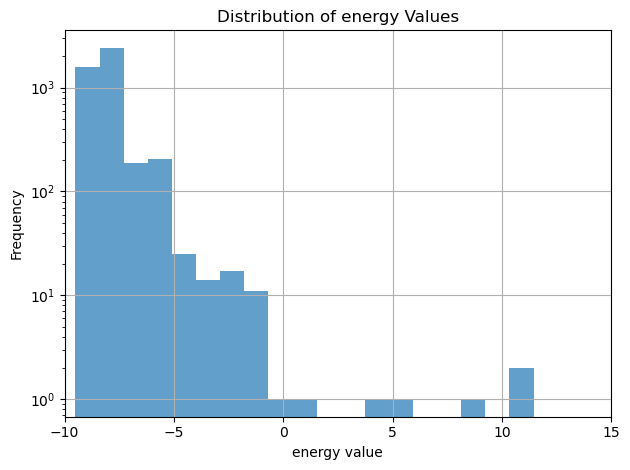

In [29]:
plt.hist(energies, bins=50, alpha=0.7)
plt.xlabel('energy value')
plt.ylabel('Frequency')
plt.title('Distribution of energy Values')
plt.xlim(-10,15)
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
prepare_aa_workflow(
    output_dir='../data/adversarial_attack/gen_7_plus_dimers',
    model_dir = '../potentials/mace_gen_6_ensemble',
    elements = None,
    n_batches_variance = 1,
    structure_type = None,
    composition_constraints = None,
    structure_ids = gen_7_plus_dimers_ids,
    hpc_profile_name = "PSFC-GPU-AA",
    debug = True,
    n_structures_aa = 25,
    hpc_profile_vasp = "PSFC-GPU",
    example_aa_n_batches = 12,
    example_selection_mode = 'total',
)

[INFO] Starting adversarial attack workflow preparation...
[INFO] Step 1: Selecting structures and saving reference data...
[DEBUG] Loading configuration...
[DEBUG] Initializing database connection...
[DEBUG] Connection established.
[DEBUG] Entering _initialize_tables...
[DEBUG] Creating structures table IF NOT EXISTS...
[DEBUG] Creating structures composition_hash index IF NOT EXISTS...
[DEBUG] Creating structures parent_id index IF NOT EXISTS...
[DEBUG] Creating calculations table IF NOT EXISTS...
[DEBUG] Creating calculations structure_id index IF NOT EXISTS...
[DEBUG] Creating calculations calculator index IF NOT EXISTS...
[DEBUG] Creating mlip_models table IF NOT EXISTS...
[DEBUG] Creating mlip_models generation index IF NOT EXISTS...
[DEBUG] Creating mlip_models type index IF NOT EXISTS...
[DEBUG] Committing transaction...
[DEBUG] Transaction committed.
[DEBUG] Exiting _initialize_tables normally.
[INFO] Using provided structure IDs: [20197, 20198, 20199, 20200, 20201, 20202, 202

Note to modify the names of variables to use the kebab style. -- Done via README

Output of step 2:
```bash
forge-aa run-gradient-aa-jobs --input-directory variance_results/ --model-dir models/ --n-structures 25 --n-batches 4 --n-iterations 60 --device cuda
[INFO] Starting Gradient AA optimization job preparation...
[INFO] Copying models from models/ to /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/gradient_aa_optimization/models
[INFO] Copied 3 models.
[INFO] Combining variance results from /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/variance_results...
[INFO] Found 1 variance result files in /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/variance_results. Combining...
[INFO] Combined 4452 unique variance results from 1 files.
[INFO] Found 4452 structures with variance results.
[INFO] Selected top 25 structures for Gradient AA based on variance.
[INFO] Splitting 25 structures into 4 AA batches (~6 per batch).
[INFO] Batch 0: Wrote 7 structures to /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/gradient_aa_optimization/batch_0/batch_0_input.xyz
[INFO] Batch 1: Wrote 6 structures to /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/gradient_aa_optimization/batch_1/batch_1_input.xyz
[INFO] Batch 2: Wrote 6 structures to /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/gradient_aa_optimization/batch_2/batch_2_input.xyz
[INFO] Batch 3: Wrote 6 structures to /home/myless/Packages/forge/scratch/data/adversarial_attack/gen_7_plus_dimers/gradient_aa_optimization/batch_3/batch_3_input.xyz
[INFO] Loading HPC profile: default
[ERROR] HPC profile 'default.json' not found.
```

Next step is to focus on fixing the HPC profiles. 

When running the adversarial attacks:

``` bash
  Average: 0.0006 seconds
==============================

\n[ERROR] An critical error occurred during execution: 'key from calculator already exists in atoms.info'
```

Additionally the probability was essentially infinite, need to figure out what's going on there. 

# Testing Outputs

In [2]:
from forge.core.database import DatabaseManager
db_manager = DatabaseManager()

gen_8_structures_ids = db_manager.find_structures_by_metadata(
    metadata_filters={
        'generation': '8'
    }
)



In [39]:

gen_8_structures = db_manager.get_batch_atoms_with_calculation(gen_8_structures_ids)


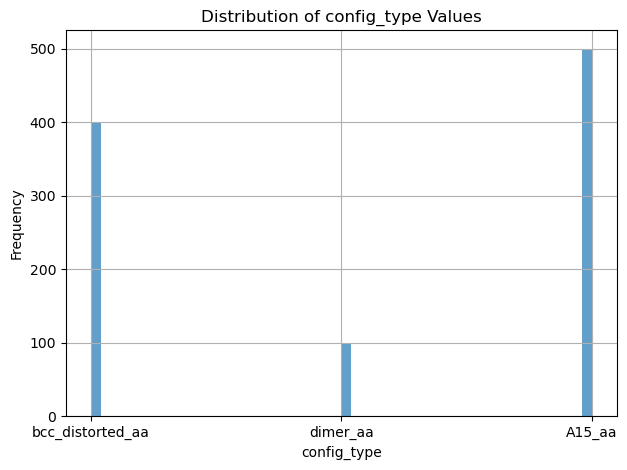

In [40]:
# create histogram of all the config_types 
config_types = [atoms.info['config_type'] for atoms in gen_8_structures]
plt.hist(config_types, bins=50, alpha=0.7)
plt.xlabel('config_type')
plt.ylabel('Frequency')
plt.title('Distribution of config_type Values')
plt.grid(True)
plt.tight_layout()

In [3]:
# remove all of the generation 8 structures from database

print(gen_8_structures_ids)

[25646, 25647, 25648, 25649, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25687, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25697, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25765, 25766, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25778, 25779, 25780, 25781, 25782, 25783, 25784, 25785, 25786, 25787, 25788

In [5]:
db_manager.remove_structures_batch(gen_8_structures_ids)

[INFO] Successfully removed 1000 structures (and associated calculations): [25646, 25647, 25648, 25649, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25687, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25697, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25765, 25766, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 